# Base Model

- Train: 75Agree_train
- Test: 75Agree_test

In [7]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def pandas_df_to_Dataset(df, tokenizer):
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(tokenizer, batched=True)
    dataset = dataset.rename_column("label", "labels")
    return dataset

### Step 1: Prepate the data to feed the model

In [ ]:
# load the training and test datasets
df_train = pd.read_csv('data/75Agree_train.csv')
df_test = pd.read_csv('data/75Agree_test.csv')

# label encoders
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# label encoding
df_train["label"] = df_train["label"].map(label2id)
df_test["label"] = df_test["label"].map(label2id)

# balance the training set: undersample to minority class
df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)
df_train.value_counts("label")

### Step 2: Models tuning

In [ ]:
# tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

# prepare for cv
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# set random search area
def get_hyperparameters():
    return {
        "num_train_epochs": int(np.random.choice([1, 2, 3])), #1,2,3,4,5
        "learning_rate": float(np.random.choice([1e-5, 1e-4, 1e-3, 1e-2])),
        "weight_decay": float(np.random.choice([0.0, 0.01, 0.05, 0.1, 0.5])),
    }

# get the cv results dataframe or create a new one
try:
    all_results = pd.read_csv("results.csv")
except FileNotFoundError:
    all_results = pd.DataFrame(columns=["num_train_epochs", "learning_rate", "weight_decay", "eval_loss"])

# start the hyperparameter tuning
for _ in range(120):
    current_hyperparameters = get_hyperparameters()
    current_hyperparameters_eval_loss = 0
    current_results = {"num_train_epochs": [], "learning_rate": [], "weight_decay": [], "eval_loss": []}

    # make sure the hyperparameters are not already evaluated
    mask = (
        (all_results['num_train_epochs'] == current_hyperparameters['num_train_epochs']) &
        (all_results['learning_rate'] == current_hyperparameters['learning_rate']) &
        (all_results['weight_decay'] == current_hyperparameters['weight_decay'])
    )
    if mask.any():
        print("Hyperparameters already evaluated, skipping...")
        continue
    else:
        print(f"Evaluating hyperparameters: {current_hyperparameters}")
    
    # tuning hyperparameters
    for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train["label"])):

        # get the folds
        df_fold_train = df_train.iloc[train_idx]
        df_fold_val = df_train.iloc[val_idx]

        # dataset preparation for huggingface transformers
        train_dataset = pandas_df_to_Dataset(df_fold_train, tokenize_function)
        val_dataset = pandas_df_to_Dataset(df_fold_val, tokenize_function)

        train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
        val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

        # the model
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)

        # hyperparameters
        training_args = TrainingArguments(
            num_train_epochs=current_hyperparameters["num_train_epochs"],
            learning_rate=current_hyperparameters["learning_rate"],
            weight_decay=current_hyperparameters["weight_decay"],
            eval_strategy="no",
            logging_strategy="no",
            report_to=None,
            dataloader_pin_memory=False,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            save_total_limit=1,
            save_steps=500,
            output_dir=f"./results/fold_{fold}",
            disable_tqdm=True,
        )

        # training the model
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
        )
        trainer.train()

        # update the evaluation loss
        current_hyperparameters_eval_loss += trainer.evaluate(eval_dataset=val_dataset)["eval_loss"]

    # update the results dataframe
    current_results["num_train_epochs"].append(current_hyperparameters["num_train_epochs"])
    current_results["learning_rate"].append(current_hyperparameters["learning_rate"])
    current_results["weight_decay"].append(current_hyperparameters["weight_decay"])
    current_results["eval_loss"].append(current_hyperparameters_eval_loss / skf.n_splits)
    all_results = pd.concat([all_results, pd.DataFrame(current_results)], ignore_index=True)

In [4]:
all_results = all_results.sort_values(by="eval_loss").reset_index(drop=True)
all_results.to_csv("results.csv", index=False)

all_results.head(3)

,num_train_epochs,learning_rate,weight_decay,eval_loss
0,2,0.0001,0.1,0.347579
1,4,0.0001,0.1,0.348092
2,3,0.0001,0.0,0.374654


### Step 3: Extract the best hyperparameters and retrain the model

In [13]:
best_hyperparameters = all_results.iloc[0]
print(f"Best hyperparameters found in {all_results.shape[0]} tested combinations:")
print(f"Num train epochs: {best_hyperparameters['num_train_epochs']}")
print(f"Learning rate: {best_hyperparameters['learning_rate']}")
print(f"Weight decay: {best_hyperparameters['weight_decay']}")

Best hyperparameters found in 19 tested combinations:
Num train epochs: 2.0
Learning rate: 0.0001
Weight decay: 0.1


In [9]:
# tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

# dataset preparation for huggingface transformers
train_dataset = pandas_df_to_Dataset(df_train, tokenize_function)
test_dataset = pandas_df_to_Dataset(df_test, tokenize_function)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    num_train_epochs=best_hyperparameters['num_train_epochs'],
    learning_rate=best_hyperparameters['learning_rate'],
    weight_decay=best_hyperparameters['weight_decay'],
    eval_strategy="steps",
    eval_steps=25,
    logging_strategy="steps",
    logging_steps=25,
    report_to=None,
    dataloader_pin_memory=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=1,
    save_steps=500,
    output_dir="./results",
)

# train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)
trainer.train()

Map: 100%|██████████| 691/691 [00:00<00:00, 3016.30 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_1270/625306911.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
25,1.018600,0.726334
50,0.719100,0.443918
75,0.471400,0.316546
100,0.274400,0.263361
125,0.227300,0.255863


TrainOutput(global_step=126, training_loss=0.5401286400026746, metrics={'train_runtime': 245.483, 'train_samples_per_second': np.float64(8.212), 'train_steps_per_second': 0.513, 'total_flos': 132609162534912.0, 'train_loss': 0.5401286400026746, 'epoch': 2.0})

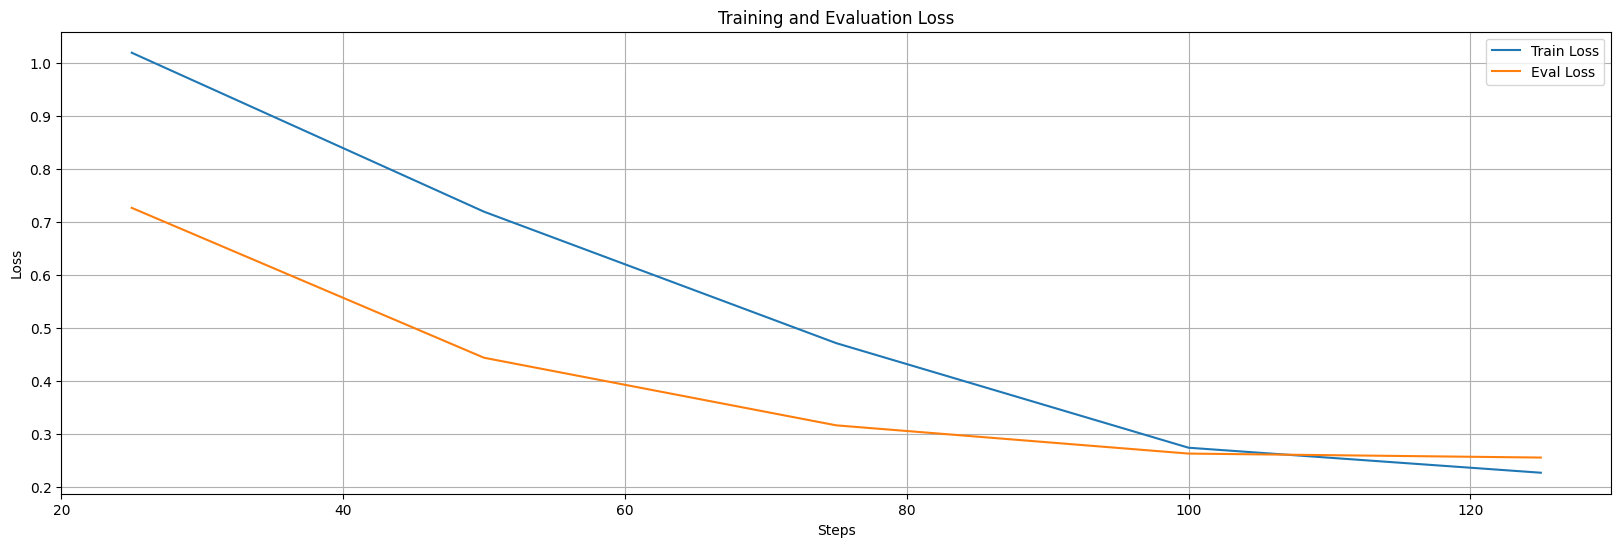

In [10]:
# get training and evaluation loss history
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
train_steps = [x["step"] for x in log_history if "loss" in x]

plt.figure(figsize=(20, 6))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Step 4: Evaluate the model


=== Classification Report (Train) ===
              precision    recall  f1-score   support

    negative       0.97      0.99      0.98       336
     neutral       0.98      0.97      0.97       336
    positive       0.97      0.96      0.97       336

    accuracy                           0.97      1008
   macro avg       0.97      0.97      0.97      1008
weighted avg       0.97      0.97      0.97      1008



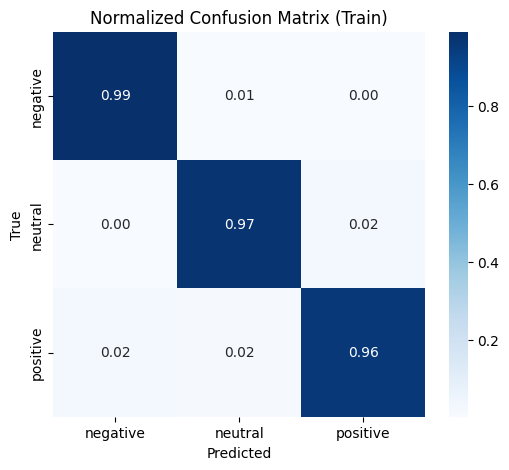


=== Classification Report (Test) ===
              precision    recall  f1-score   support

    negative       0.82      0.95      0.88        84
     neutral       0.97      0.92      0.94       429
    positive       0.85      0.89      0.87       178

    accuracy                           0.92       691
   macro avg       0.88      0.92      0.90       691
weighted avg       0.92      0.92      0.92       691



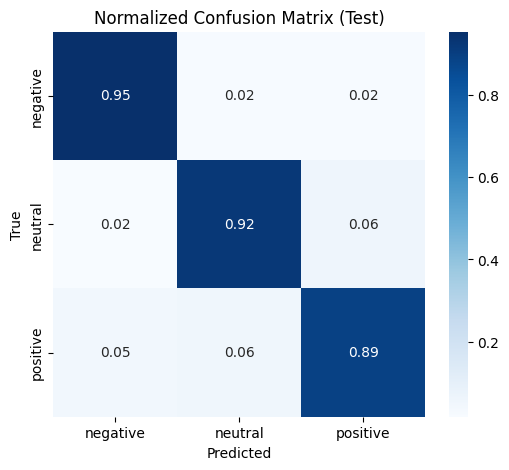

In [11]:
def evaluate_dataset(dataset, split_name):
    output = trainer.predict(dataset)
    preds = np.argmax(output.predictions, axis=1)
    y_true = output.label_ids

    print(f"\n=== Classification Report ({split_name}) ===")
    print(classification_report(y_true, preds, target_names=["negative", "neutral", "positive"]))

    cm = confusion_matrix(y_true, preds, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["negative", "neutral", "positive"],
                yticklabels=["negative", "neutral", "positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Normalized Confusion Matrix ({split_name})")
    plt.show()

# evaluate the model on the training and test datasets
evaluate_dataset(train_dataset, "Train")
evaluate_dataset(test_dataset, "Test")